In [1]:
import numpy as np
from scipy import spatial,stats
import pandas as pd
import time
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

#### Test and Train split is done in the common way; using 20:80 ratio and considering whole dataset. This split willbe used only for finding K and trust values

In [7]:
import os
print (os.getcwd())

D:\Academics_research\research\BKPatra\Attacks_RS\Implementaion\filmtrust\Item-Based-Recommendation


In [8]:
train=pd.read_csv('D:\\Academics_research\\research\\BKPatra\\Attacks_RS\\Implementaion\\filmtrust\\data\\train.csv',usecols=[1,2,3])
test=pd.read_csv('D:\\Academics_research\\research\\BKPatra\\Attacks_RS\\Implementaion\\filmtrust\\data\\test.csv',usecols=[1,2,3])

In [9]:
train.describe()

,userId,itemId,rating
count,28913.000000,28913.000000,28913.000000
mean,744.727424,265.519593,3.003562
std,433.220556,347.806295,0.918015
min,1.000000,1.000000,0.500000
25%,359.000000,12.000000,2.500000
50%,735.000000,216.000000,3.000000
75%,1130.000000,251.000000,4.000000
max,1508.000000,2071.000000,4.000000


In [10]:
train.shape

(28913, 3)

### Inject profiles

In [11]:
calculated_Rating = {}
items = train['itemId'].unique()

#rating
R = train.groupby(['itemId'])['rating'].mean()
for i in items:
#     print (i)
    calculated_Rating[i] = R[i]
    
# print (calculated_Rating)

In [12]:
window_items =  [256, 1, 257, 6, 10, 12, 205, 206, 207, 210, 84, 212, 213, 214, 216, 217, 220, 121, 233, 234, 235, 239, 241, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253, 254, 255] 
target_items = [2, 3, 4, 5, 7, 8, 9, 11, 13, 17, 211, 215, 219, 236, 250]

In [13]:
nuke_rating = 0.5

In [14]:
attack_ids = list(range(1600,1700))

for attacker in attack_ids:
    for item in window_items:
        a = calculated_Rating[item]
        attack_rating = int(a) if (a-int(a)<0.5) else int(a)+1
        train = train.append(pd.Series([attacker,item,attack_rating], index=['userId', 'itemId' ,'rating']), ignore_index=True)

for attacker in attack_ids:
    for item in target_items:
        train = train.append(pd.Series([attacker,item,nuke_rating], index=['userId', 'itemId' ,'rating']), ignore_index=True)

In [15]:
train.shape

(33913, 3)

### Creating trust value matrix

In [16]:
trust_dim = int(train['userId'].max()+1)
sim = np.zeros(shape=(trust_dim,trust_dim))
conf = np.zeros(shape=(trust_dim,trust_dim))

### Calculating User-User Trust values

In [17]:
users = train['userId'].unique()
users.sort()

In [18]:
max_i = int(train['itemId'].max())

t1=time.time()

for index,trustor in enumerate(users):
    if(index%10 == 0):
        print (index)
    trustor = int(trustor)  
    trustor_rated = train[train['userId']==trustor]
    trustor_vec = np.zeros(max_i)
    for i1,t_v in enumerate(trustor_rated.itertuples(),1):
        trustor_vec[int(t_v.itemId-1)] = t_v.rating
        
    for trustee in users: 
        trustee = int(trustee)
        trustee_rated = train[train['userId']==trustee]
        trustee_vec = np.zeros(max_i)
        for i2,t_w in enumerate(trustee_rated.itertuples(),1):
            trustee_vec[int(t_w.itemId-1)] = t_w.rating

        sim[trustor][trustee] = stats.pearsonr(trustor_vec,trustee_vec)[0]
        xt=pd.merge( trustor_rated,trustee_rated,how='inner',on=['itemId'])
        conf[trustor][trustee]  = xt.shape[0]/trustor_rated.shape[0]
            
t2=time.time()        

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600


In [19]:
print (t2-t1)

37649.33593535423


In [20]:
with h5py.File('Sim_Conf_user.h5', 'w') as hf:
    hf.create_dataset("PCC similarity",  data=sim)
    hf.create_dataset("confidence",  data=conf)

//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------//

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
with h5py.File('Sim_Conf_user.h5', 'r') as hf:
    sim = hf['PCC similarity'][:]
    conf = hf['confidence'][:]

### Calculating trust values

In [ ]:
trust_dim = sim.shape[0]
trust_val = np.zeros(shape=(trust_dim,trust_dim))

k_trust = 0.25
for i in range(1,trust_dim,1):
    for j in range(1,trust_dim,1):
        temp_sim = sim[i][j]
        temp_conf = conf[i][j]
        if(temp_sim ==0 and temp_conf==0):
            trust_val[i][j] = 0
        elif(temp_sim ==0 and temp_conf!=0):
            trust_val[i][j] = k_trust*temp_conf
        elif(temp_sim !=0 and temp_conf!=0):
            trust_val[i][j] = 2*temp_sim*temp_conf/(temp_sim+temp_conf)

In [ ]:
with h5py.File('trust_values_user.h5', 'w') as hf:
    hf.create_dataset("trust",  data=trust_val)

In [3]:
with h5py.File('trust_values_user.h5', 'r') as hf:
    trust_val = hf['trust'][:]

In [4]:
len(np.where(trust_val>0.6)[0])

272109

In [5]:
x = [i for i in range(0,11)]
y = []
total = trust_val.shape[0]*trust_val.shape[1]
for i in x:
    y.append(len(np.where(trust_val>(i/10))[0])/total)

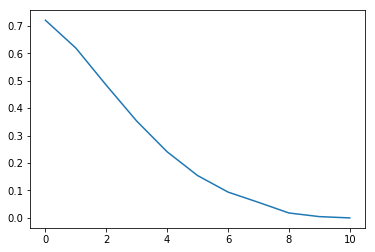

In [6]:
plt.plot(x,y)